In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import plotly.express as px
from ac_models import RLC_T, integral_controller,standard_capacity,capacity_cost
import sys 
sys.path.append('/Users/wuzhenxiong/主营科研/红宝石项目/23年三月份整合/stat_mod_sim')


In [2]:
from scores import scores

In [3]:
from dateutil import parser
import dateutil.parser as dp

In [4]:
#四号开始
dataframes = {}

for i in [5,6,8]: #有效数据
    dataframes['df'+str(i)] = pd.read_csv('arranged_data/sub_df'+str(i)+'.csv')
    dataframes['df'+str(i)]['平均温度'] = 0.5 * (dataframes['df'+str(i)]['1号室内温度'] + dataframes['df'+str(i)]['2号室内温度'])



## 灯具散热量 + 自然进风热量

In [5]:
from led_models import modules_control,round_1_led
whites = [0,0,0,0,20,25,10,13,0]
blues = [23,28,12,15,0,0,0,0,12]
reds_1 = [26,31,30,36,0,0,13,16,30]
reds_2 = [0,0,0,0,0,0,0,0,0,10]
standard_lights_power, standard_lights_heat = round_1_led()#modules_control(whites,blues,reds_1,reds_2)

for i in [5,6,8]:
    led_heat = []
    df = dataframes['df'+str(i)]
    for i in range(len(df)):
        if df['1号PPFD'][i]<1:
            led_heat.append(0)
        else:
            led_heat.append(standard_lights_heat/1000)
    df['灯散热'] = led_heat #kW
    df['自然散热'] = (df['户外温度'] - df['平均温度']) * 1.1 * 0.5 * 1.005 * 1.29 #kW #循环风机自然进热#循环风机要一直开所以一直有热量进入
    dataframes['df'+str(i)] = df


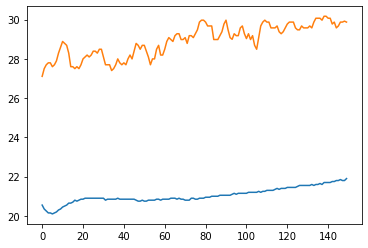

In [6]:
df['平均温度'].plot()
df['户外温度'].plot()

## 热特性识别

In [9]:
nat_dissip = pd.read_excel('14-15-16全部统计.xlsx', sheet_name='15-16-17综合数据')

In [10]:
nat_dissip.where(nat_dissip['空调运行模式']=='关闭',inplace=True)

In [11]:
nat_dissip.dropna(inplace=True)

In [12]:
nat_dissip_1 = nat_dissip.iloc[:117,:]
nat_dissip_2 = nat_dissip.iloc[117:,:]

/Users/wuzhenxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuzhenxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuzhenxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuzhenxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuzhenxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22806 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuzhenxiong/opt/anaconda3/li

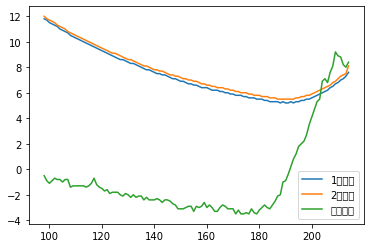

In [13]:
nat_dissip_1[['1号温度','2号温度','户外温度']].plot()

In [14]:
# 自然循环进风口面积0.5 m2,
# 风速1.1 m/s
# 1.005 kJ/(kg.K)
# 1.29 kg/m3
nat_cir_inputs = (- nat_dissip_1['平均温度'] + nat_dissip_1['户外温度']) * 1.1 * 0.5 * 1.005 * 1.29

In [15]:
nat_cir_diff = nat_cir_inputs.diff(1)

nat_cir_diff.iloc[0] = 0

nat_cir_diff, nat_cir_inputs

(98     0.000000
 99    -0.213914
 100    0.000000
 101    0.213914
 102    0.213914
          ...   
 210   -0.285219
 211   -0.285219
 212   -0.427829
 213   -0.285219
 214   -0.071305
 Length: 117, dtype: float64,
 98    -8.841789
 99    -9.055703
 100   -9.055703
 101   -8.841789
 102   -8.627875
          ...   
 210    1.426095
 211    1.140876
 212    0.713047
 213    0.427828
 214    0.356524
 Length: 117, dtype: float64)

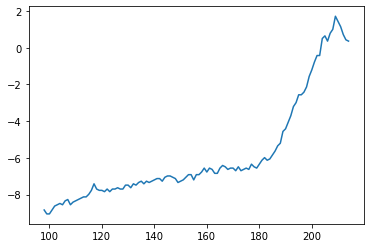

In [21]:
nat_cir_inputs.plot()

In [16]:
xdata_T1 = nat_dissip_1['1号温度'][:-1], nat_dissip_1['2号温度'][:-1],nat_dissip_1['户外温度'][:-1], nat_cir_inputs[:-1]/2, nat_cir_diff[:-1]/2, nat_dissip_1['2号湿度'][:-1]
xdata_T2 = nat_dissip_1['2号温度'][:-1], nat_dissip_1['1号温度'][:-1],nat_dissip_1['户外温度'][:-1], nat_cir_inputs[:-1]/2, nat_cir_diff[:-1]/2, nat_dissip_1['1号湿度'][:-1]

In [17]:
T1_paras, T1_covs = curve_fit(RLC_T, xdata=xdata_T1, ydata=nat_dissip_1['1号温度'][1:])
T2_paras, T2_covs = curve_fit(RLC_T, xdata=xdata_T2, ydata=nat_dissip_1['2号温度'][1:])

In [18]:
r2_score(RLC_T(xdata_T1, *T1_paras), nat_dissip_1['1号温度'][1:])

0.9994843569381018

In [19]:
T1_paras

array([ 5.85821093e-03,  1.00125887e+00, -1.78783321e-03,  8.77259069e-03,
       -3.57521951e-05])

In [20]:
T2_paras

array([ 2.76391629e-02,  2.69490859e-01, -8.86426840e-03, -1.94016714e-02,
        3.48308859e-05])

## 空调性能分析

In [25]:
#空调有关数据集合

#制冷，除湿，送风，制热

df = dataframes['df8']

xdata_standard = df['空调手动模式选择'][:-1],df['新风机手动开度'][:-1], df['空调风速选择'][:-1], df['户外温度'][:-1], df['平均温度'][:-1], df['灯散热'][:-1]+df['自然散热'][:-1]

ac_params, ac_covs = curve_fit(standard_capacity, xdata_standard, df['平均温度'][1:], p0=np.concatenate([[0.1 for i in range(5)] for i in range(5)])) #1热容-4新风参数-(5空调参数-4空调模式)


/Users/wuzhenxiong/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [26]:
df

,Unnamed: 0,Unnamed: 0.1,空调光期温度设定,空调暗期温度设定,空调温度上限设定,空调温度下限设定,新风机手动开度,新风机手自动模式,空调自动模式,户外温度,...,空调手动模式选择,空调风速选择,空调手动温度设定,空调手动操作指令下发,空调手自动切换,time,平均温度,平均湿度,灯散热,自然散热
0,3470,3470,23.0,20.0,18.0,17.0,17.0,False,False,27.106480,...,1,7,20.0,False,False,2023-03-10 10:59:23.659365,20.550000,55.200001,0,4.675081
1,3471,3471,23.0,20.0,18.0,17.0,17.0,False,False,27.500000,...,1,7,20.0,False,False,2023-03-10 11:00:24.593285,20.349999,54.600000,0,5.098290
2,3472,3472,23.0,20.0,18.0,17.0,17.0,False,False,27.693867,...,1,7,20.0,False,False,2023-03-10 11:01:25.508553,20.250000,55.150000,0,5.307831
3,3473,3473,23.0,20.0,18.0,17.0,17.0,False,False,27.795139,...,1,7,20.0,False,False,2023-03-10 11:02:26.403318,20.150001,55.949999,0,5.451347
4,3474,3474,23.0,20.0,18.0,17.0,17.0,False,False,27.795139,...,1,7,20.0,False,False,2023-03-10 11:03:27.284293,20.150001,57.250000,0,5.451347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3615,3615,23.0,20.0,18.0,17.0,30.0,False,False,29.673035,...,1,4,20.0,False,False,2023-03-10 13:26:42.982752,21.800000,60.799999,0,5.613848
146,3616,3616,23.0,20.0,18.0,17.0,30.0,False,False,29.869789,...,1,4,20.0,False,False,2023-03-10 13:27:43.818265,21.850000,59.900000,0,5.718490
147,3617,3617,23.0,20.0,18.0,17.0,30.0,False,False,29.869789,...,1,4,20.0,False,False,2023-03-10 13:28:44.641491,21.800000,61.000000,0,5.754143
148,3618,3618,23.0,20.0,18.0,17.0,25.0,False,False,29.918980,...,1,4,20.0,False,False,2023-03-10 13:29:45.487941,21.800000,61.049999,0,5.789218


In [27]:
ac_params

array([ 4.37857123e-04,  7.89168829e+04,  5.32139014e-03, -1.18839369e-05,
        6.87670811e-09,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        1.00000000e-01, -7.89241960e+04,  5.52296963e-02, -4.90014315e-04,
        1.19503676e-06, -7.89153530e+04, -2.36002479e-01,  2.16369476e-03,
       -5.90584844e-06,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        1.00000000e-01,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        1.00000000e-01])

In [40]:
test_x = 1, 10, 3, 20, 12, 9
#模式，开度，档位，室外温度，室内温度，其它热源
standard_capacity(test_x, *ac_params)

12.10109234465718

In [ ]:
dataframes3

In [41]:
capacity_cost(test_x,*ac_params) #kW

-78922.38810752258

In [13]:
test = standard_capacity(xdata_standard,*ac_params)
real = df['平均温度'][1:]
px.line(x=df['time'][1:],y=[test,real])

scores(test,real)

([0.9986316034499458], [0.015516230170175857], [0.038448814909743764])

In [14]:
df_val = dataframes['df8']

xdata_val = df_val['空调手动模式选择'][:-1],df_val['新风机手动开度'][:-1], df_val['空调风速选择'][:-1], df_val['户外温度'][:-1], df_val['平均温度'][:-1], df_val['灯散热'][:-1]+df_val['自然散热'][:-1]

fit = standard_capacity(xdata_val, *ac_params)
for i in range(len(fit)):
    if fit[i]>real.max():
        fit[i] = fit[i-1]
real = df_val['平均温度'][1:]

px.line(x=df_val['time'][1:],y=[fit,real])

scores(fit,real)

([0.98180531067466], [0.028806904750363575], [0.11590625960725799])

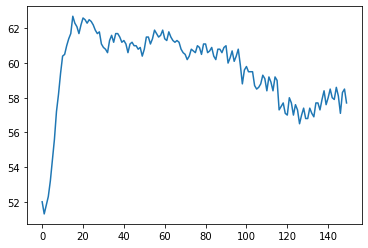

In [15]:
df_val['1号室内湿度'].plot()

In [16]:
dataframes2 = {}
for i in range(7): #有效数据
    dataframes2['df'+str(i)] = pd.read_csv('arranged_data2/sub_df'+str(i)+'.csv')
    df_val = dataframes2['df'+str(i)]
    xdata_val = df_val['空调手动模式选择'][:-1],df_val['新风机手动开度'][:-1], df_val['空调风速选择'][:-1], df_val['户外温度'][:-1], df_val['平均温度'][:-1], df_val['灯散热'][:-1]+df_val['自然散热'][:-1]
    fit = standard_capacity(xdata_val, *ac_params)
    real = df_val['平均温度'][1:]
    print(scores(fit,real))

([0.932620265131376], [0.2491439122649854], [0.4927816767190024])
([0.8389684737384863], [0.03763046661686613], [0.179460894858882])
([0.8704774921588203], [0.1560292796148607], [0.41492933813822913])
([0.9446024196785694], [0.04280044775372907], [0.14879303772068522])
([0.9387403978288906], [0.1491283137179597], [0.233474334497969])
([0.8389525360158013], [0.05428228618581241], [0.2606253345319049])
([-1.069900677970371], [0.07733853800115609], [0.37250215339042303])


In [27]:
df_val = dataframes2['df3']

xdata_val = df_val['空调手动模式选择'][:-1],df_val['新风机手动开度'][:-1], df_val['空调风速选择'][:-1], df_val['户外温度'][:-1], df_val['平均温度'][:-1], df_val['灯散热'][:-1]+df_val['自然散热'][:-1]

fit = standard_capacity(xdata_val, *ac_params)
#for i in range(len(fit)):
#    if fit[i]>real.max():
#        fit[i] = fit[i-1]
real = df_val['平均温度'][1:]

#px.line(x=df_val['time'][1:],y=[fit,real])

scores(fit,real)

([0.9446024196785694], [0.04280044775372907], [0.14879303772068522])

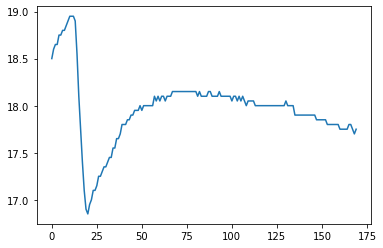

In [28]:
df_val['平均温度'].plot()
#df_val['1号室内温度'].plot()
#df_val['2号室内温度'].plot()

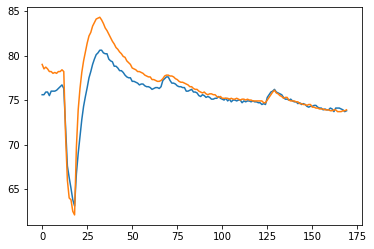

In [29]:
df_val['1号室内湿度'].plot()
df_val['2号室内湿度'].plot()

In [20]:
ac_params

array([ 8.92751574e-04,  4.39775663e+03,  1.24648290e-01,  6.18729622e-05,
       -2.52688024e-07, -4.34076134e+03, -5.35758014e+07,  1.87427738e+06,
       -1.63921590e+04, -4.46615018e+03,  3.02108664e+00, -3.99388585e-02,
        1.30820179e-04, -4.40338182e+03, -1.90721189e-01,  5.96518646e-03,
       -3.43988311e-05, -4.36807979e+03, -4.76863219e+00,  1.66390841e-01,
       -1.63821151e-03,  1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
        1.00000000e-01])

In [15]:
df_val['空调手动模式选择'][:-1]

0       1
1       1
2       1
3       1
4       1
       ..
1374    1
1375    1
1376    1
1377    1
1378    1
Name: 空调手动模式选择, Length: 1379, dtype: int64

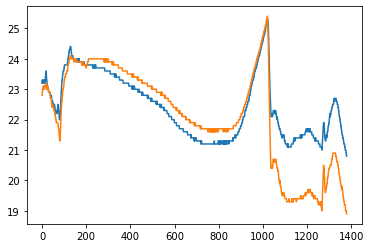

In [22]:
df['1号室内温度'].plot()
df['2号室内温度'].plot()

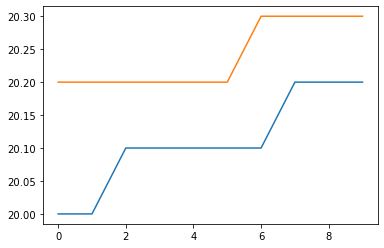

In [28]:
df_val['1号室内温度'].plot()
df_val['2号室内温度'].plot()

## 耗电分析

In [37]:
AC_consum = pd.read_excel('14-15-16全部统计.xlsx',sheet_name='16空调电量数据')

In [38]:
AC_consum['时间差(s)'] =[dp.parse(str(AC_consum['时间'][0])) - dp.parse(str(AC_consum['时间'][0]))] + [dp.parse(str(AC_consum['时间'][i])) - dp.parse(str(AC_consum['时间'][i-1])) for i in range(1,len(AC_consum))]
AC_consum['时间差(s)'] = [i.seconds for i in AC_consum['时间差(s)']] #和上一时刻对比 / 已经运行某组合多长时间

In [ ]:
AC_consum['电量差']

In [41]:
0.55/11

0.05

In [39]:
AC_consum

,时间,电量,此前空调设定温度,对应空调运行模式,对应新风开度,对应室内平均温度,室内湿度,CO2浓度,户外温度,时间差(s)
0,17:10:00,91.70,18,送风,4,18.6,61.3,610,5.9,0
1,17:15:00,91.75,26,送风,71,18.5,61.7,612,5.7,300
2,17:16:00,91.76,26,送风,71,18.5,61.7,612,5.7,60
3,17:17:00,91.76,18,制热,14,18.1,61.4,618,5.4,60
4,17:18:00,91.79,18,制热,14,18.1,61.4,618,5.4,60
5,17:19:00,91.83,18,制热,14,18.1,61.4,618,5.4,60
6,17:21:00,91.89,24,制热,57,18.1,61.4,618,5.4,120
7,17:22:00,91.97,24,制热,57,18.0,62.9,622,5.1,60
8,17:24:00,92.12,30,制热,100,18.0,62.9,622,5.1,120
9,17:25:00,92.18,30,制热,100,18.0,62.9,622,5.1,60


In [ ]:
# 主要问题在于空调风速当时是未知的；那个界面没反应
#@关于空调开度：考虑设定温度与室内平均温度之差
# 时间差 * 运行模式 * (pack(上一时刻设定实际温差) + pack(新风开度))


